<a href="https://colab.research.google.com/github/Rishabh-Shukla-15/HateSpeechAI/blob/main/hateSpeechModelCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q  scikit-learn matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score


print('TensorFlow:', tf.__version__)

TensorFlow: 2.19.0


In [ ]:
df = pd.read_csv('Twitter_Data.csv')
print(df.shape)
df.head()

(162980, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df['label'] = df['category'] + 1
df['label'].value_counts()

,count
label,
2.0,72250
1.0,55213
0.0,35510


In [ ]:
# Check missing values
print(df.isna().sum())

clean_text    4
category      7
label         7
dtype: int64


In [ ]:
# Convert NaN to string safely
df['clean_text'] = df['clean_text'].astype(str)

# Remove empty or useless tweets
df = df[df['clean_text'].str.strip() != '']
df = df[df['clean_text'].str.lower() != 'nan']

print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (162975, 3)


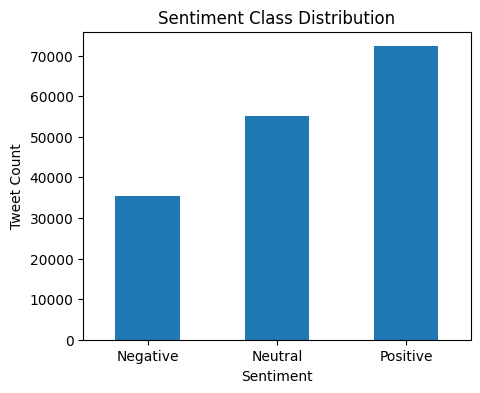

In [ ]:
plt.figure(figsize=(5,4))
df['label'].value_counts().sort_index().plot(kind='bar')

plt.xticks(
    ticks=[0,1,2],
    labels=['Negative','Neutral','Positive'],
    rotation=0
)

plt.title('Sentiment Class Distribution')
plt.ylabel('Tweet Count')
plt.xlabel('Sentiment')
plt.show()


In [ ]:
# Token count per tweet (vectorized → fast)
df['tweet_len'] = df['clean_text'].str.split().str.len()

print(df['tweet_len'].describe())


count    162975.000000
mean         20.080540
std          10.879418
min           1.000000
25%          11.000000
50%          18.000000
75%          29.000000
max          52.000000
Name: tweet_len, dtype: float64


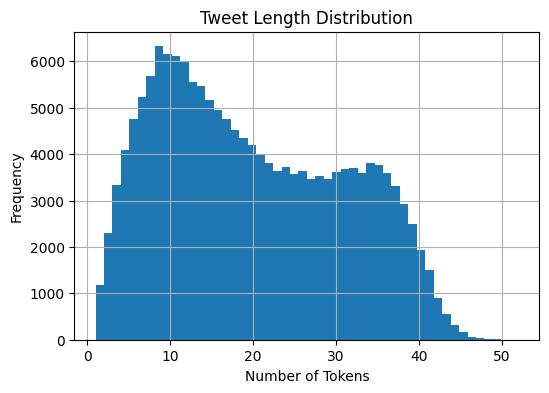

In [ ]:
plt.figure(figsize=(6,4))
df['tweet_len'].hist(bins=50)
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


In [ ]:
print(f"""
Final Dataset Summary
---------------------
Total Tweets   : {len(df):,}
Avg Length     : {df['tweet_len'].mean():.2f}
Max Length     : {df['tweet_len'].max()}
Min Length     : {df['tweet_len'].min()}
""")



Final Dataset Summary
---------------------
Total Tweets   : 162,975
Avg Length     : 20.08
Max Length     : 52
Min Length     : 1



In [ ]:
# Check NaNs in label
print(df['label'].isna().sum())

# Remove rows with invalid labels
df = df.dropna(subset=['label'])

# Convert label to int
df['label'] = df['label'].astype(int)

print("After label cleaning:", df.shape)


7
After label cleaning: (162968, 4)


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp['label'],
    random_state=42
)

print(df_train.shape, df_val.shape, df_test.shape)


(130374, 4) (16297, 4) (16297, 4)


In [ ]:
MAX_VOCAB  = 50_000     # enough for Twitter language
MAX_LEN    = 50         # based on EDA
BATCH_SIZE = 1024       # stable for large data


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(
    num_words=MAX_VOCAB,
    oov_token="<OOV>"
)

tokenizer.fit_on_texts(df_train['clean_text'])

print("Vocabulary size:", len(tokenizer.word_index))


Vocabulary size: 98820


In [ ]:
def tokenize_and_pad(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(
        sequences,
        maxlen=MAX_LEN,
        padding='post',
        truncating='post'
    )
    return padded


In [ ]:
X_train = tokenize_and_pad(df_train['clean_text'])
X_val   = tokenize_and_pad(df_val['clean_text'])
X_test  = tokenize_and_pad(df_test['clean_text'])

y_train = df_train['label'].values
y_val   = df_val['label'].values
y_test  = df_test['label'].values


In [ ]:
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape  :", X_val.shape, y_val.shape)
print("Test shape :", X_test.shape, y_test.shape)

print("Sample sequence:", X_train[0])


Train shape: (130374, 50) (130374,)
Val shape  : (16297, 50) (16297,)
Test shape : (16297, 50) (16297,)
Sample sequence: [   9    3  114  214   23   73 2138 1437    2 3062  154    7  853   49
 7029    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

def build_rnn():
    model = Sequential([
        Embedding(
            input_dim=MAX_VOCAB,
            output_dim=128,
            input_length=MAX_LEN
        ),
        SimpleRNN(128),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

rnn_model = build_rnn()
rnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 3   # enough for large dataset

history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5339 - loss: 0.9582 - val_accuracy: 0.6405 - val_loss: 0.9121
Epoch 2/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7400 - loss: 0.6207 - val_accuracy: 0.8233 - val_loss: 0.4467
Epoch 3/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8520 - loss: 0.4086 - val_accuracy: 0.6391 - val_loss: 0.8593


In [ ]:
from tensorflow.keras.layers import LSTM

def build_lstm():
    model = Sequential([
        Embedding(
            input_dim=MAX_VOCAB,
            output_dim=128,
            input_length=MAX_LEN
        ),
        LSTM(128),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

lstm_model = build_lstm()
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5233 - loss: 0.9716 - val_accuracy: 0.7232 - val_loss: 0.7124
Epoch 2/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7848 - loss: 0.5425 - val_accuracy: 0.8816 - val_loss: 0.3337
Epoch 3/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8999 - loss: 0.2913 - val_accuracy: 0.9348 - val_loss: 0.2048


In [ ]:
from tensorflow.keras.layers import Bidirectional

def build_bilstm():
    model = Sequential([
        Embedding(
            input_dim=MAX_VOCAB,
            output_dim=128,
            input_length=MAX_LEN
        ),
        Bidirectional(LSTM(128)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

bilstm_model = build_bilstm()
bilstm_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5962 - loss: 0.8489 - val_accuracy: 0.9209 - val_loss: 0.2385
Epoch 2/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9444 - loss: 0.1853 - val_accuracy: 0.9488 - val_loss: 0.1668
Epoch 3/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9711 - loss: 0.1045 - val_accuracy: 0.9534 - val_loss: 0.1654


In [ ]:
import transformers
import tensorflow as tf

print("Transformers:", transformers.__version__)
print("TensorFlow:", tf.__version__)

Transformers: 4.38.2
TensorFlow: 2.19.0


In [ ]:
# !pip install transformers==4.38.2

In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, create_optimizer

print("TensorFlow:", tf.__version__)

MODEL_NAME = "distilbert-base-uncased"

# Load tokenizer
tokenizer_bert = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

MAX_LEN_BERT = 64

def bert_encode(texts):
    return tokenizer_bert(
        list(texts),
        padding=True,
        truncation=True,
        max_length=MAX_LEN_BERT,
        return_tensors="tf"
    )

# Encode datasets
X_train_bert = bert_encode(df_train['clean_text'])
X_val_bert   = bert_encode(df_val['clean_text'])
X_test_bert  = bert_encode(df_test['clean_text'])

BATCH_SIZE_BERT = 32

train_bert_ds = tf.data.Dataset.from_tensor_slices(
    (dict(X_train_bert), y_train)
).shuffle(10000).batch(BATCH_SIZE_BERT)

val_bert_ds = tf.data.Dataset.from_tensor_slices(
    (dict(X_val_bert), y_val)
).batch(BATCH_SIZE_BERT)

test_bert_ds = tf.data.Dataset.from_tensor_slices(
    (dict(X_test_bert), y_test)
).batch(BATCH_SIZE_BERT)

# Load model
bert_model = TFDistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)

EPOCHS_BERT = 2
num_train_steps = len(train_bert_ds) * EPOCHS_BERT

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

# IMPORTANT: No manual loss
bert_model.compile(optimizer=optimizer)

# Train
history_bert = bert_model.fit(
    train_bert_ds,
    validation_data=val_bert_ds,
    epochs=EPOCHS_BERT
)

TensorFlow: 2.19.0


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
4075/4075 [==============================] - 959s 227ms/step - loss: 0.2235 - val_loss: 0.1063
Epoch 2/2
4075/4075 [==============================] - 898s 220ms/step - loss: 0.0751 - val_loss: 0.0715


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate
test_loss = bert_model.evaluate(test_bert_ds)

# Predictions
bert_pred_logits = bert_model.predict(test_bert_ds).logits
bert_pred = np.argmax(bert_pred_logits, axis=1)

bert_acc = accuracy_score(y_test, bert_pred)
bert_f1  = f1_score(y_test, bert_pred, average='weighted')

print("BERT Accuracy:", bert_acc)
print("BERT F1 Score:", bert_f1)

print(classification_report(
    y_test,
    bert_pred,
    target_names=["Negative", "Neutral", "Positive"]
))

510/510 [==============================] - 43s 78ms/step
BERT Accuracy: 0.9777259618334663
BERT F1 Score: 0.9777233742660006
              precision    recall  f1-score   support

    Negative       0.96      0.96      0.96      3551
     Neutral       0.99      0.98      0.98      5521
    Positive       0.98      0.98      0.98      7225

    accuracy                           0.98     16297
   macro avg       0.98      0.98      0.98     16297
weighted avg       0.98      0.98      0.98     16297



In [ ]:
rnn_pred_probs = rnn_model.predict(X_test)
rnn_pred = np.argmax(rnn_pred_probs, axis=1)

rnn_acc = accuracy_score(y_test, rnn_pred)
rnn_f1  = f1_score(y_test, rnn_pred, average='weighted')

print("RNN Accuracy:", rnn_acc)
print("RNN F1:", rnn_f1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
RNN Accuracy: 0.6437381113088299
RNN F1: 0.6243205006147184


In [ ]:
lstm_pred_probs = lstm_model.predict(X_test)
lstm_pred = np.argmax(lstm_pred_probs, axis=1)

lstm_acc = accuracy_score(y_test, lstm_pred)
lstm_f1  = f1_score(y_test, lstm_pred, average='weighted')

print("LSTM Accuracy:", lstm_acc)
print("LSTM F1:", lstm_f1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Accuracy: 0.9311529729398049
LSTM F1: 0.9310817560511103


In [ ]:
bilstm_pred_probs = bilstm_model.predict(X_test)
bilstm_pred = np.argmax(bilstm_pred_probs, axis=1)

bilstm_acc = accuracy_score(y_test, bilstm_pred)
bilstm_f1  = f1_score(y_test, bilstm_pred, average='weighted')

print("BiLSTM Accuracy:", bilstm_acc)
print("BiLSTM F1:", bilstm_f1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
BiLSTM Accuracy: 0.9517702644658526
BiLSTM F1: 0.9514667543856535


In [ ]:
# bert_pred_probs = bert_model.predict(test_bert_ds).logits
# bert_pred = np.argmax(bert_pred_probs, axis=1)

# bert_acc = accuracy_score(y_test, bert_pred)
# bert_f1  = f1_score(y_test, bert_pred, average='weighted')

# print("BERT Accuracy:", bert_acc)
# print("BERT F1:", bert_f1)

In [ ]:
comparison = pd.DataFrame({
    "Model": ["RNN", "LSTM", "BiLSTM", "DistilBERT"],
    "Accuracy": [rnn_acc, lstm_acc, bilstm_acc, bert_acc],
    "F1 Score": [rnn_f1, lstm_f1, bilstm_f1, bert_f1]
})

print(comparison)

        Model  Accuracy  F1 Score
0         RNN  0.643738  0.624321
1        LSTM  0.931153  0.931082
2      BiLSTM  0.951770  0.951467
3  DistilBERT  0.977726  0.977723


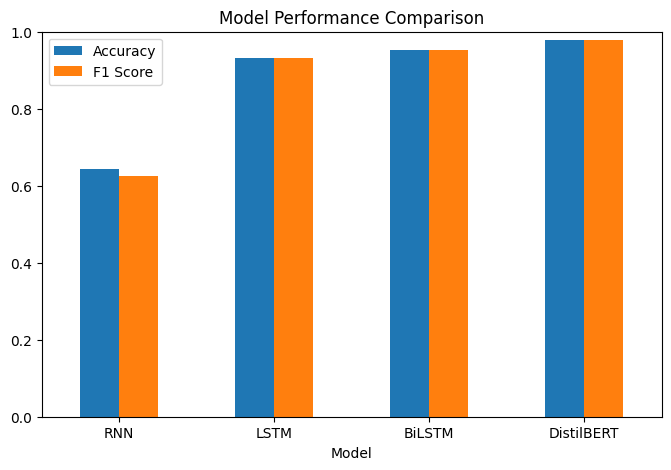

In [ ]:
comparison.set_index("Model")[["Accuracy","F1 Score"]].plot(kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()

In [ ]:
# ==============================
# STEP 1: Save Model & Tokenizer
# ==============================

SAVE_FOLDER = "saved_bert_model"

bert_model.save_pretrained(SAVE_FOLDER)
tokenizer_bert.save_pretrained(SAVE_FOLDER)

print("Model and tokenizer saved inside Colab.")


# ==============================
# STEP 2: Zip the Folder
# ==============================

!zip -r bert_model.zip saved_bert_model

print("Folder zipped successfully.")


# ==============================
# STEP 3: Download to Your Computer
# ==============================

from google.colab import files
files.download("bert_model.zip")

print("Download started. Check your browser downloads.")